In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!mkdir -p "/content/dataset"
!cp -r "/content/drive/My Drive/imagewoof2-160" "/content/dataset/"

In [4]:
import os
import random
import time
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, f1_score

In [9]:
# ----- Device configuration -----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
!nvidia-smi

Using device: cuda
Tue Apr 22 18:16:20 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   45C    P0             28W /   72W |     253MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+----------------------------

In [ ]:
class ImageWoofDataset(Dataset):
    def __init__(self, csv_file, root_dir, label_column='noisy_labels_0',
                 transform=None, split='train', poisoned_data_pct=0.0):
        """
        Args:
            csv_file (str): Path to the CSV file (e.g. 'noisy_imagewoof.csv').
            root_dir (str): Path to the root directory containing the images.
            label_column (str): Which column to use for labels.
            transform (callable, optional): Optional transform to be applied.
            split (str): 'train' or 'val', determined by the 'is_valid' column.
            poisoned_data_pct (float): Fraction of training data to randomly poison at access-time.
        """
        self.df = pd.read_csv(csv_file)

        # Filter rows based on the split.
        if split == 'train':
            self.df = self.df[self.df['is_valid'] == False].reset_index(drop=True)
        else:
            self.df = self.df[self.df['is_valid'] == True].reset_index(drop=True)

        self.root_dir = root_dir
        self.label_column = label_column
        self.transform = transform
        self.split = split
        self.poisoned_data_pct = poisoned_data_pct

        # Create a mapping from synset strings to integer labels.
        synsets = self.df[self.label_column].unique()
        self.synset_to_idx = {synset: idx for idx, synset in enumerate(synsets)}
        self.num_classes = len(self.synset_to_idx)

        # Store label indices in a list for direct access and mutation.
        self.targets = [self.synset_to_idx[label] for label in self.df[self.label_column]]

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.root_dir, row['path'])
        image = Image.open(img_path).convert("RGB")

        label = self.targets[idx]

        # Optional access-time poisoning
        if self.split == 'train' and self.poisoned_data_pct > 0.0:
            if random.random() < self.poisoned_data_pct:
                label = random.randint(0, self.num_classes - 1)

        if self.transform:
            image = self.transform(image)

        return image, label

In [31]:
# -----------------------------
# Dataset Paths and Transforms
# -----------------------------
csv_file = '/content/dataset/imagewoof2-160/noisy_imagewoof.csv'
root_dir = '/content/dataset/imagewoof2-160'
label_column = 'noisy_labels_0'
poisoned_data_pct = 0.0  # For example, poison 10% of the training data.

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

# Create train and validation datasets.
train_dataset = ImageWoofDataset(csv_file=csv_file,
                                 root_dir=root_dir,
                                 label_column=label_column,
                                 transform=transform,
                                 split='train',
                                 poisoned_data_pct=poisoned_data_pct)

val_dataset = ImageWoofDataset(csv_file=csv_file,
                               root_dir=root_dir,
                               label_column=label_column,
                               transform=transform,
                               split='val',
                               poisoned_data_pct=0)  # No poisoning in validation.

# Create DataLoaders.
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

print("Number of training images:", len(train_dataset))
print("Number of validation images:", len(val_dataset))

Number of training images: 9025
Number of validation images: 3929


In [28]:
# -----------------------------
# Load Pretrained ResNet18 and Fine-Tune
# -----------------------------
num_classes = 15

# Load a pretrained ResNet18.
model = models.resnet18(pretrained=True)
# Replace the final fully connected layer.
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_classes)
model = model.to(device)

In [29]:
# -----------------------------
# Loss Function and Optimizer
# -----------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003)

# -----------------------------
# Training Loop
# -----------------------------
num_epochs = 15
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
val_recalls = []
train_recalls = []
val_f1s = []
train_f1s = []

In [30]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    train_all_preds = []
    train_all_labels = []
    start_time = time.time()

    # Training loop: accumulate predictions and labels for training metrics.
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        # Accumulate training predictions and labels.
        train_all_preds.extend(predicted.cpu().numpy())
        train_all_labels.extend(labels.cpu().numpy())

    epoch_train_loss = running_loss / total_train
    epoch_train_acc = 100.0 * correct_train / total_train
    epoch_train_recall = recall_score(train_all_labels, train_all_preds, average="macro")
    epoch_train_f1 = f1_score(train_all_labels, train_all_preds, average="macro")

    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)
    train_recalls.append(epoch_train_recall)
    train_f1s.append(epoch_train_f1)

    # Evaluate on validation set:
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    val_all_preds = []
    val_all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

            # Accumulate predictions and true labels for validation metrics.
            val_all_preds.extend(predicted.cpu().numpy())
            val_all_labels.extend(labels.cpu().numpy())

    epoch_val_loss = val_loss / total_val
    epoch_val_acc = 100.0 * correct_val / total_val
    epoch_val_recall = recall_score(val_all_labels, val_all_preds, average="macro")
    epoch_val_f1 = f1_score(val_all_labels, val_all_preds, average="macro")

    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc)
    val_recalls.append(epoch_val_recall)
    val_f1s.append(epoch_val_f1)

    elapsed = time.time() - start_time
    print(f"Epoch [{epoch+1}/{num_epochs}]"
          f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}%, "
          f"Train Recall: {epoch_train_recall:.4f}, Train F1: {epoch_train_f1:.4f} | "
          f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%, "
          f"Val Recall: {epoch_val_recall:.4f}, Val F1: {epoch_val_f1:.4f} in {elapsed:.2f} sec")


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [1/15]Train Loss: 1.0977, Train Acc: 72.76%, Train Recall: 0.5478, Train F1: 0.5510 | Val Loss: 0.5227, Val Acc: 86.33%, Val Recall: 0.8460, Val F1: 0.8505 in 16.13 sec
Epoch [2/15]Train Loss: 0.4415, Train Acc: 88.64%, Train Recall: 0.8776, Train F1: 0.8799 | Val Loss: 0.3856, Val Acc: 88.80%, Val Recall: 0.8742, Val F1: 0.8776 in 16.22 sec
Epoch [3/15]Train Loss: 0.3255, Train Acc: 90.87%, Train Recall: 0.9007, Train F1: 0.9029 | Val Loss: 0.3227, Val Acc: 90.56%, Val Recall: 0.8995, Val F1: 0.8987 in 16.13 sec
Epoch [4/15]Train Loss: 0.2645, Train Acc: 92.74%, Train Recall: 0.9219, Train F1: 0.9234 | Val Loss: 0.2855, Val Acc: 91.47%, Val Recall: 0.9042, Val F1: 0.9069 in 16.14 sec
Epoch [5/15]Train Loss: 0.2143, Train Acc: 94.48%, Train Recall: 0.9406, Train F1: 0.9417 | Val Loss: 0.2757, Val Acc: 91.40%, Val Recall: 0.9033, Val F1: 0.9066 in 16.22 sec
Epoch [6/15]Train Loss: 0.1861, Train Acc: 95.02%, Train Recall: 0.9459, Train F1: 0.9473 | Val Loss: 0.2702, Val Acc: 91.17%

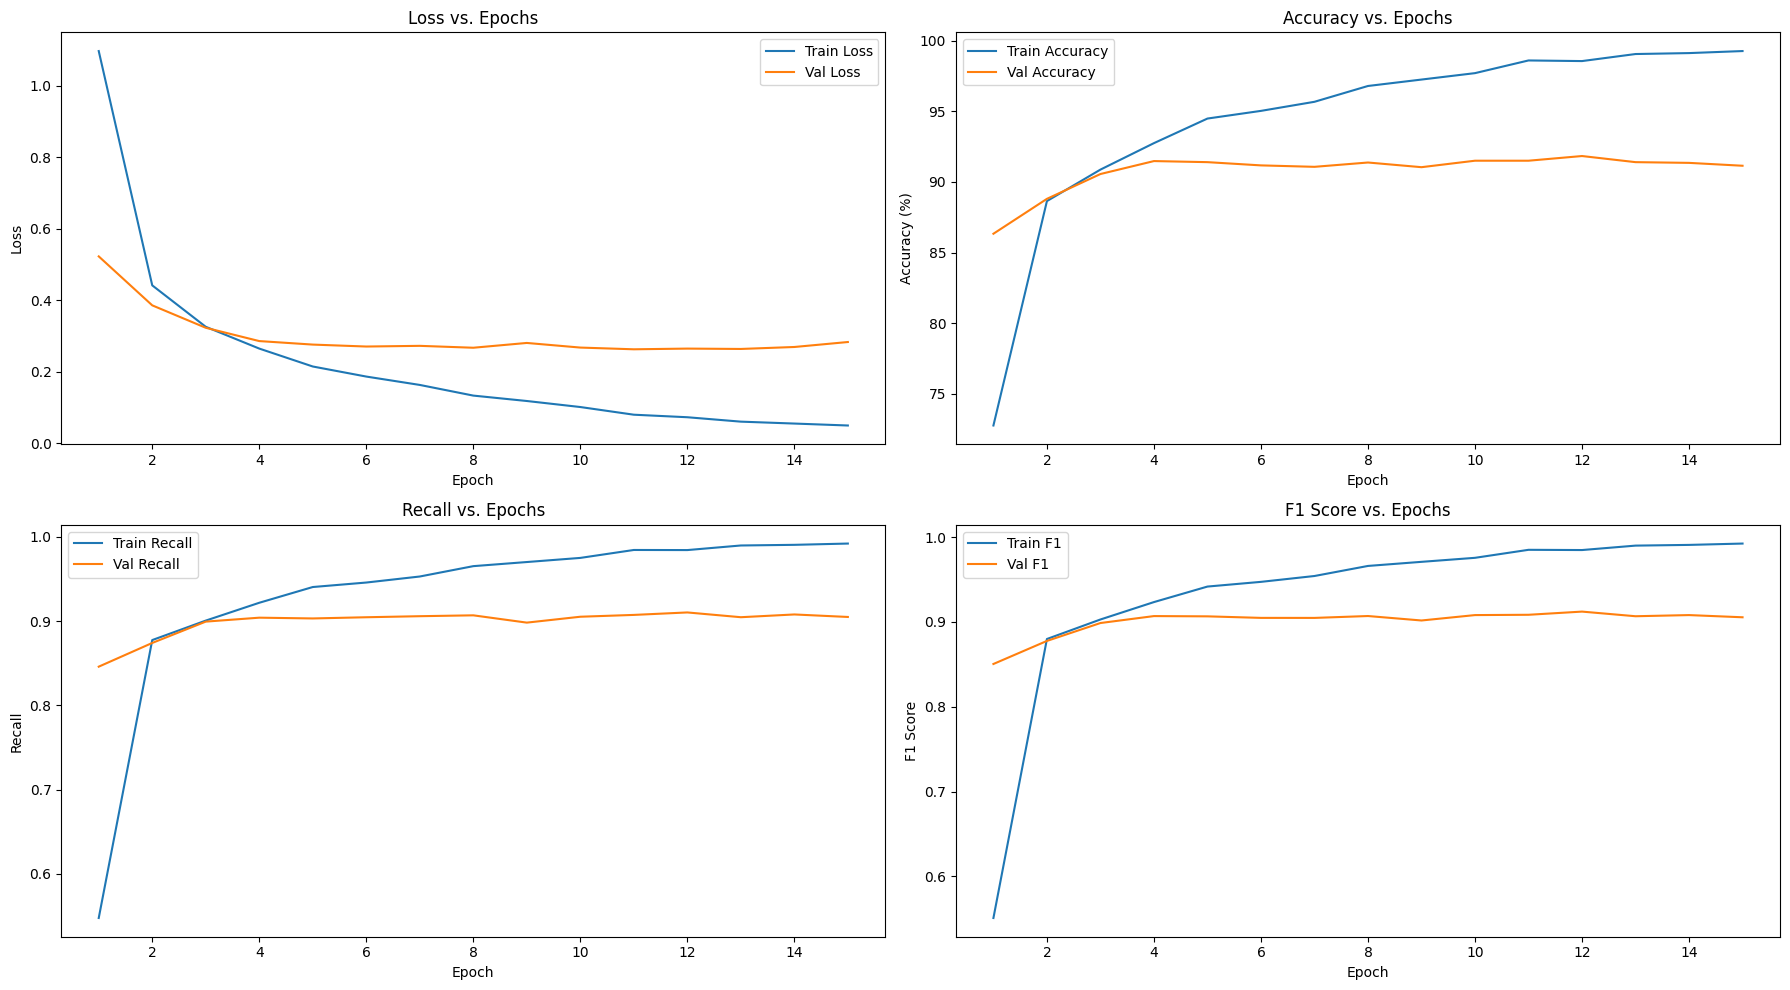

In [32]:
# -----------------------------
# Plotting Training and Validation Performance
# -----------------------------
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(18, 10))

# Loss Plot
plt.subplot(2, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs. Epochs")
plt.legend()

# Accuracy Plot
plt.subplot(2, 2, 2)
plt.plot(epochs, train_accuracies, label="Train Accuracy")
plt.plot(epochs, val_accuracies, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs. Epochs")
plt.legend()

# Recall Plot
plt.subplot(2, 2, 3)
plt.plot(epochs, train_recalls, label="Train Recall")
plt.plot(epochs, val_recalls, label="Val Recall")
plt.xlabel("Epoch")
plt.ylabel("Recall")
plt.title("Recall vs. Epochs")
plt.legend()

# F1 Score Plot
plt.subplot(2, 2, 4)
plt.plot(epochs, train_f1s, label="Train F1")
plt.plot(epochs, val_f1s, label="Val F1")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.title("F1 Score vs. Epochs")
plt.legend()

plt.tight_layout()
plt.show()
